In [143]:
import pandas as pd 
import numpy as np 
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import trange
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


In [144]:
SEED = 40

In [145]:
np.random.seed(seed=SEED)

In [146]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(367, 64)  # 6*6 from image dimension
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 5)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x



In [147]:
#ground truth
clusters = pd.read_csv('dataset_5000samples/clusters.txt', sep='\t')

meth = pd.read_csv('dataset_5000samples/meth.txt', sep='\t' ).T
meth.columns = meth.loc['probe',:]
meth = meth.drop('probe')

mRNA = pd.read_csv('dataset_5000samples/mRNA.txt', sep='\t').T
mRNA.columns = mRNA.loc['probe',:]
mRNA = mRNA.drop('probe')

prot = pd.read_csv('dataset_5000samples/prot.txt', sep='\t').T
prot.columns = prot.loc['probe',:]
prot = prot.drop('probe')

In [148]:
X = np.array(meth.values,dtype=np.float32)
Y = np.array(clusters['cluster.id'].apply(lambda x: x-1).values,dtype=np.float32)

X_train, X_test, Y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=SEED, stratify = Y)


  0%|          | 0/500 [00:00<?, ?it/s]/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()
loss 0.19 accuracy 1.00: 100%|██████████| 500/500 [00:03<00:00, 136.04it/s]


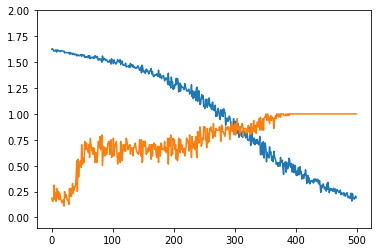

In [157]:
#training
model = Net()
BS = 64
loss_function = nn.CrossEntropyLoss(reduction='none')
optim = torch.optim.SGD(model.parameters(),lr = 0.01, momentum=0.2)
losses, accuracies = [], []
t = trange(500)
for i in t: 
    samp = np.random.randint(0,X_train.shape[0],size = (BS), )
    X = torch.tensor(torch.from_numpy(X_train[samp]).reshape(-1,367))
    Y = torch.tensor(torch.from_numpy(Y_train[samp])).long()
    model.zero_grad()
    out = model(X)
    cat = torch.argmax(out, dim = 1)
    acc = (cat==Y).float().mean()
    loss = loss_function(out,Y).mean()
    loss.backward()
    optim.step()
    loss,accuracy = loss.item(),acc.item()
    losses.append(loss)
    accuracies.append(accuracy)
    t.set_description("loss %.2f accuracy %.2f" %(loss,accuracy))
plt.ylim(-0.1,2)
plt.plot(losses)
plt.plot(accuracies)

In [158]:
y_pred = torch.argmax(model(torch.from_numpy(X_test)), dim = 1).detach().numpy()
accuracy_score(y_test, y_pred)

1.0